# Step Two Build Single Photon Model
* synchronises every trace to the middle of the acquisition window
* averages down the traces to create a first approximation of an average pulse
* use this first approximation to build a model
* fit all the traces again using this model, and use the fitted offset values to synchronise the pulses again
* once synchronised, average down to create a better approximation of a single photon model

In [1]:
from __future__ import division
import tqdm, os, sys
sys.path.append('/mnt/disk0/home/jianwei_leejw/scripts/TESPulseFitCode')
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import glob
from lmfit import Model, Parameters

from multiprocess import Pool
import trace_param as tp
import heralded_pulses_analysis as hpa
import pulse_averaging_cw as pacw
import pulse_utils as pu
results_directory = './'

In [2]:
# Import Single Photon Filelist
filelist_1ph = np.loadtxt(results_directory + 'filelist_single_photon.dat', dtype='string')
num_of_1ph_traces = len(filelist_1ph)
sample_size = 10000
print('{} of {} n=1 traces will be sampled for creating the single photon model'.format(sample_size, num_of_1ph_traces))

10000 of 75195 n=1 traces will be sampled for creating the single photon model


In [5]:
# Import/Set discriminator settings
[height_th, offset] = np.loadtxt(results_directory + 'disc_settings.dat')
offset = int(offset)
print height_th, offset

0.00953609 850


In [4]:
# Synchronise each single photon pulse to t = 0
# Generate average pulse
reload(pacw)
time_p, signal_p = pacw.trace_ave(filelist_1ph[:sample_size], 
                                  high_th = height_th,
                                  low_th = 0,
                                  offset = offset)

/usr/local/lib/python2.7/dist-packages/peakutils/peak.py:216: UserWarning: Optimal parameters not found: Number of calls to function has reached maxfev = 800.
  warnings.warn(str(e))


In [5]:
# Use average pulse to generate single photon model
def one_pulse(x, x_offset=0, amplitude=1):
    """convert the sample single photon pulse into a function
    that can be used in a fit
    """
    x = x - x_offset
    return amplitude * np.interp(x, time_p, signal_p)

fit_model = Model(one_pulse)

In [6]:
# Use model to generate another model that has horizontal offset correction
reload(pacw)
time_f, signal_f, sigma_f = pacw.fit_corrected_pulse(filelist_1ph[:sample_size],
                                                     high_th = height_th,
                                                     low_th = 0,
                                                     offset = offset,
                                                     fit_model = fit_model)

## Pulse Characteristics

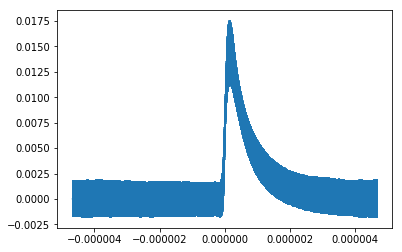

signal max = 14.39 mV
SNR = 3.5
risetime = 128.00 ns


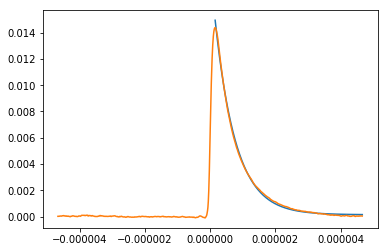

decaytime = 641.62 ns


In [7]:
# Plot model with rise time
reload(pu)
plt.figure()
plt.errorbar(time_f, signal_f, yerr=sigma_f)
plt.show()
print 'signal max = {:.2f} mV'.format(np.max(signal_f)*1000)
sigma0 = np.loadtxt(results_directory + 'rms.dat')
print 'SNR = {:.1f}'.format(np.max(signal_f)/(2.355*sigma0))
print 'risetime = {:.2f} ns'.format(pu.rise_time(time_f,signal_f,plot=False)*1e9)
print 'decaytime = {:.2f} ns'.format(pu.decay_time(time_f,signal_f,plot=True)*1e9)

In [6]:
# Typical Length of single-photon pulse identified by discriminator
if os.path.isfile(results_directory + 'ph1_model_from_cw_disc.dat'):
    time_f, signal_f, sigma_f = np.loadtxt(results_directory + 'ph1_model_from_cw_disc.dat').T

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
  after removing the cwd from sys.path.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 4670 but corresponding boolean dimension is 4669
  after removing the cwd from sys.path.


[ -1.21999997e-07   4.43999987e-07]


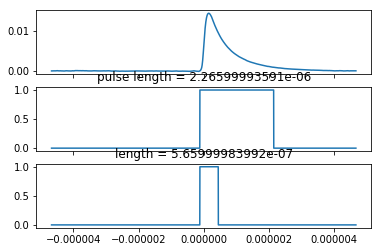

In [9]:
reload(pu)
mask_ext = pu.disc_peak_full(signal_f,height_th,1e-5,offset) # set the low threshold to about 1e-5, in case the model trace is 'floating' above zero a little bit, and the mask doesn't trigger.
mask = pu.disc_peak_full(signal_f,height_th,1e-5,0)
print time_f[(mask[:-1]-mask[1:])>0]
f, axarr = plt.subplots(3,1,sharex=True)
# plt.xlim(-5e-7,4e-7)
axarr[0].plot(time_f,signal_f)
axarr[1].plot(time_f,mask_ext)
axarr[2].plot(time_f,mask)
axarr[1].set_title('pulse length = {}'.format(np.sum(mask_ext)*np.diff(time_f)[0]))
axarr[2].set_title('length = {}'.format(np.sum(mask)*np.diff(time_f)[0]))
plt.show()

In [10]:
reload(pu)
lengths = np.array(Pool(3).map(lambda f: pu.disc_length(pu.time_vector(f),
                                                tp.trace_extr(f),
                                                height_th,
                                                0,
                                                offset
                                               ),
                       filelist_1ph[:sample_size]))

<IPython.core.display.Javascript object>


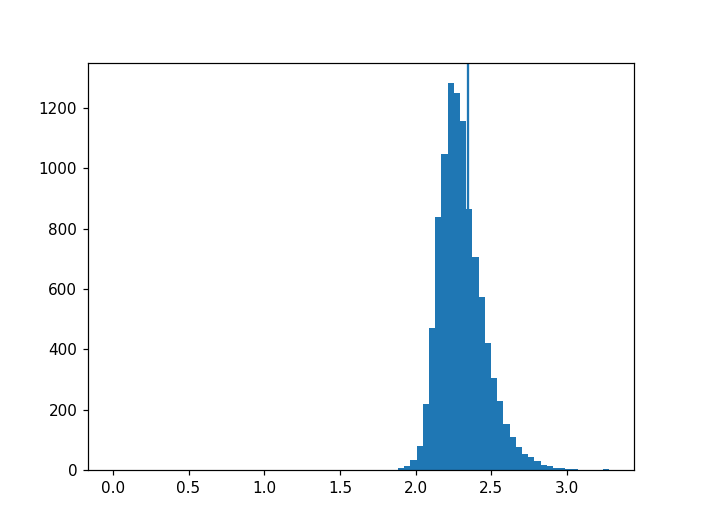

mode [ 2.23177494] median 2.2839999354e-06 mean 2.30632013477e-06


(2.3063201347728102e-06, -37.179865227189964, 150.52002056348988)

In [11]:
%matplotlib notebook
plt.figure()
h = plt.hist(lengths*1e6,80);
f,b = np.histogram(lengths*1e6,80);
plt.axvline(2.3435)
print 'mode', (b[:-1]+np.diff(b)[0]/2)[f==np.max(f)], 'median', np.median(lengths), 'mean', np.mean(lengths)
plt.show()
np.mean(lengths), (np.mean(lengths)*1e6-2.3435)*1e3, np.std(lengths)*1e9

# Time of Arrival Distribution of Single Photons
convoluting this with itself produces the expected g2

In [12]:
reload(pu)
starts = np.array(Pool(23).map(lambda f: pu.time_init(pu.time_vector(f),
                                                tp.trace_extr(f),
                                                height_th,
                                                0,
                                                offset
                                               ),
                       filelist_1ph[:sample_size]))

In [13]:
np.sum(starts==0) # faulty events

1

In [14]:
starts_=starts[starts!=0]-np.min(starts[starts!=0]) # remove faulty events labeled with starts = 0

In [15]:
np.savetxt('disc_starts_1ph.dat',starts_)

<IPython.core.display.Javascript object>


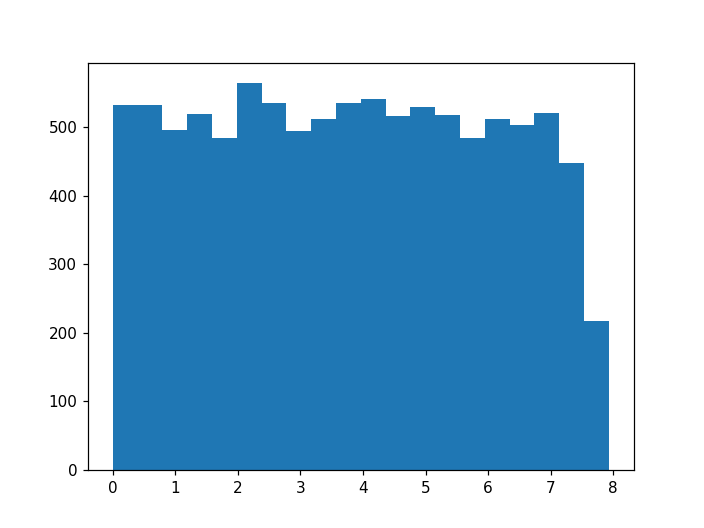

In [16]:
%matplotlib notebook
plt.figure()
h = plt.hist(starts_*1e6,20);
# plt.xlim(0,1)

# Time of Arrival of Single Photons (Fitted)

In [17]:
if os.path.isfile(results_directory + 'ph1_model_from_cw_disc.dat'):
    time_f, signal_f, sigma_f = np.loadtxt(results_directory + 'ph1_model_from_cw_disc.dat').T

In [18]:
def one_pulse(x, x_offset=0, amplitude=1):
    """convert the sample single photon pulse into a function
    that can be used in a fit
    """
    x = x - x_offset
    return amplitude * np.interp(x, time_f, signal_f)

fit_model = Model(one_pulse)

In [19]:
reload(pacw)
toa = np.array(Pool(23).map(lambda f: pacw.time_fitted(pu.time_vector(f),
                                                tp.trace_extr(f),
                                                fit_model = fit_model,
                                                high_th = height_th,
                                                low_th = 0,
                                                offset = offset
                                               ),
                       filelist_1ph[:sample_size]))

In [20]:
toa_ = np.array([t for t in toa if isinstance(t,np.float64)])

<IPython.core.display.Javascript object>


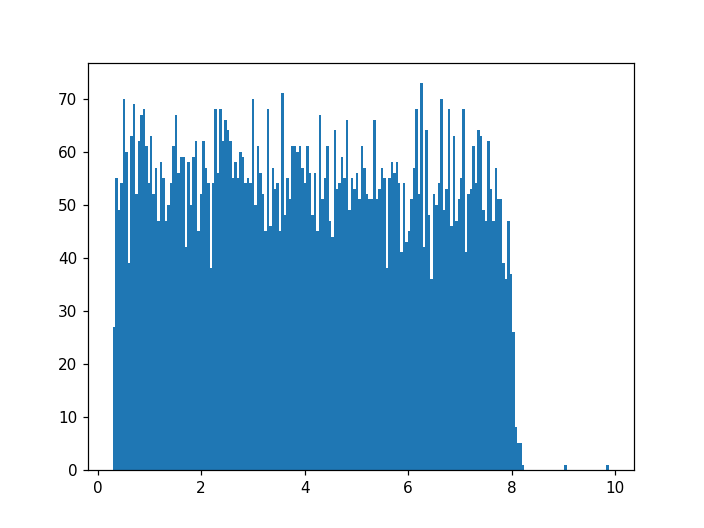

In [21]:
%matplotlib notebook
plt.figure()
h = plt.hist(np.array(toa_)*1e6,200);

In [22]:
print np.max(toa_)
toa__ = toa_[toa_<9e-6]

9.87862605104e-06


In [23]:
np.savetxt('time_of_arrival_1ph.dat',toa__)

## Area of Single photon model
check that this does not differ significantly from g1 center - they may not matcch since g1 center is obtained from fitting a wider domain than that used for the generation of the single photon model.

In [24]:
np.sum(np.abs(signal_f[mask_ext]))

0.0

# Save single photon model with uncertainty

In [25]:
np.savetxt(results_directory + 'ph1_model_from_cw_disc.dat',
           np.array(zip(time_f, signal_f, sigma_f)),
           delimiter = '\t',
           header='time\tsignal\tsigma')